## Setup

In [179]:
# RUN SETUP.SH BEFORE RUNNING THIS IPYNB
# REQUIREMENTS FOR SETUP.SH:
# python 3.11.8
# pip 23.3.1

import pandas as pd
import pickle
from sklearn.metrics import f1_score, precision_recall_fscore_support, accuracy_score
from sklearn.naive_bayes import MultinomialNB # Naive Bayes Classifier
from sklearn.linear_model import LogisticRegression # Logistic Regression Classifier
from sklearn.neural_network import MLPClassifier # Multi Layer Perceptron, simple Neural Network
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import ADASYN, RandomOverSampler
from scipy.sparse import hstack, csr_matrix, save_npz, load_npz
import spacy
import re
import numpy as np
from spacytextblob.spacytextblob import SpacyTextBlob
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectPercentile, chi2, f_regression, mutual_info_classif
import nltk
from readability import Readability
# import text2emotion as te
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler
from collections import Counter


In [180]:
SEED = 42 # seed random state for comparison, testing
PARTITION_SIZE = 500 # Adjust lower if potato PC and higher if gaming rig or want results closer to actual
enable_all_data = True # SET TO FALSE IF PREPROCESSING TAKES A LONG TIME (True = test on PARTITION_SIZE training and PARTITION_SIZE testing samples)

## Pre-processing

In [181]:
### Jian Hui start

In [182]:
df = pd.read_csv('raw_data/fulltrain.csv', header=None, index_col = False)
df.head()

,0,1
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [183]:
df = df if enable_all_data else df.sample(n=PARTITION_SIZE, random_state=SEED)

X_train = df.iloc[:, 1] 
y_train = df.iloc[:, 0]
X_train_unprocessed = X_train
print(X_train)
print(y_train)

print(len(X_train))
print(len(y_train))

y_train.value_counts()

0        A little less than a decade ago, hockey fans w...
1        The writers of the HBO series The Sopranos too...
2        Despite claims from the TV news outlet to offe...
3        After receiving 'subpar' service and experienc...
4        After watching his beloved Seattle Mariners pr...
                               ...                        
48849    The ruling Kuomintang (KMT) has claimed owners...
48850    The Taipei city government has encouraged the ...
48851    President Ma Ying-jeou said Friday that a park...
48852    The families of the four people who were kille...
48853    The Ministry of Finance will make public on Sa...
Name: 1, Length: 48854, dtype: object
0        1
1        1
2        1
3        1
4        1
        ..
48849    4
48850    4
48851    4
48852    4
48853    4
Name: 0, Length: 48854, dtype: int64
48854
48854


0
3    17870
1    14047
4     9995
2     6942
Name: count, dtype: int64

In [184]:
# Processing data: tokenize the text for NLP Machine Learning
# Lemmatization, Case-folding (lowercase), Stopword removal, Punctuation removal
# Eric
personal_pronouns = ["i", "me", "mine", "my", "myself", "our", "ours", "we", \
                     "their", "you", "your", "he", "she", "it", "its", "we", "they", "me", \
                     "him", "her", "us", "them", "his", "hers", "herself", \
                        "himself", "itself", "themselves", "ourselves", "yourself", "yourselves"]
spacy_preprocess_model = spacy.load("en_core_web_lg")
spacy_preprocess_model.Defaults.stop_words -= set(personal_pronouns)

# def preprocess(sentence):
#     '''
#     Preprocessing strategies:
#     1) Tokenization
#     2) Punctuation removal
#     3) Stopword removal
#     4) Lemmatization
#     5) Lowercase
#     '''
#     tokens = spacy_preprocess_model(sentence)
#     ls_sentence = [token.lemma_.lower() for token in tokens if not (token.is_punct and token not in ["!", "?"]) and not token.is_stop]
#     return ls_sentence

In [185]:
# Processing data: tokenize the text for NLP Machine Learning
# Case-folding (lowercase), Stopword removal, Punctuation removal

def preprocess(sentence):
    '''
    Preprocessing strategies:
    1) Tokenization
    2) Punctuation removal
    3) Stopword removal
    4) Lowercase
    '''
    tokens = spacy_preprocess_model(sentence)
    ls_sentence = [token.text.lower() for token in tokens if not (token.is_punct and token not in ["!", "?"]) and not token.is_stop]
    return ls_sentence

In [186]:
# Processing data: tokenize the text for NLP Machine Learning
# Case-folding (lowercase), Punctuation removal

# def preprocess(sentence):
#     '''
#     Preprocessing strategies:
#     1) Tokenization
#     2) Punctuation removal
#     3) Lowercase
#     '''
#     tokens = spacy_preprocess_model(sentence)
#     ls_sentence = [token.text.lower() for token in tokens if not (token.is_punct and token not in ["!", "?"])]
#     return ls_sentence

In [187]:
# Processing data: tokenize the text for NLP Machine Learning
# pos (TAG), Punctuation removal

# def preprocess(sentence):
#     '''
#     Preprocessing strategies:
#     1) Tokenization
#     2) Punctuation removal
#     3) POS tag
#     '''
#     tokens = spacy_preprocess_model(sentence)
#     ls_sentence = [token.tag_ for token in tokens if not (token.is_punct and token not in ["!", "?"])]
#     return ls_sentence

In [188]:
# To be used by features for feature extraction:
# X_train_ls = X_train.apply(preprocess)
# X_train_sentence = X_train_ls.apply(lambda sentence: ' '.join(sentence))

# X_train_ls = X_train
# X_train_sentence = X_train_ls

### Save and load preprocessed data

In [189]:
# X_train_sentence.head()

In [190]:
# Save pre-processed data
# compression_opts = dict(method='zip', archive_name='strip_punct_stop_lower.csv')
# X_train_sentence.to_csv('strip_punct_stop_lower.zip', index=False, compression=compression_opts)

In [191]:
# quickload pre-processed data
# replace 'raw_data/*.csv' with .csv file containing preprocessed data
X_train = pd.read_csv('strip_punct_stop_lower.csv', index_col=False).iloc[:, 0]
# X_train.head()

# Reload constants if preprocessing cells are not executed
personal_pronouns = ["i", "me", "mine", "my", "myself", "our", "ours", "we", \
                     "their", "you", "your", "he", "she", "it", "its", "we", "they", "me", \
                     "him", "her", "us", "them", "his", "hers", "herself", \
                        "himself", "itself", "themselves", "ourselves", "yourself", "yourselves"]
spacy_model = spacy.load("en_core_web_lg")
spacy_model.Defaults.stop_words -= set(personal_pronouns)
spacy_model.add_pipe('spacytextblob')

### Train-Validation Split

In [192]:
# X_train_unprocessed, X_val_unprocessed, _, _ = train_test_split(X_train_unprocessed, y_train, test_size=0.2, random_state=SEED)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED)

### Feature analysis

In [193]:
def count_analysis_bar(X, y, feature_name):
    unique_y = np.unique(y)
    fig, axs = plt.subplots(len(unique_y), 1, figsize=(8, len(unique_y) * 4))
    for i in unique_y:
        indices = np.where(y == i)[0]
        counts_i = X[indices]
        unique_vals, counts = np.unique(counts_i, return_counts=True)
        axs[i-1].bar(unique_vals, counts)
        axs[i-1].set_xlabel(f'{feature_name}')
        axs[i-1].set_ylabel(f'Frequency of {feature_name}')
        axs[i-1].set_title(f'Distribution of {feature_name} for class {i}')

    plt.tight_layout()
    plt.savefig(f'plots/{feature_name}_analysis_plot.png')

def count_analysis_scatter(X, y, feature_name):
    unique_y = np.unique(y)
    fig, axs = plt.subplots(len(unique_y), 1, figsize=(8, len(unique_y) * 4))
    for i in unique_y:
        indices = np.where(y == i)[0]
        counts_i = X[indices]
        unique_vals, counts = np.unique(counts_i, return_counts=True)
        axs[i-1].scatter(unique_vals, counts)
        axs[i-1].set_xlabel(f'{feature_name}')
        axs[i-1].set_ylabel(f'Frequency of {feature_name}')
        axs[i-1].set_title(f'Distribution of {feature_name} for class {i}')

    plt.tight_layout()
    plt.savefig(f'plots/{feature_name}_analysis_plot.png')

def count_analysis_boxplot(X, y, feature_name):
    unique_y = np.unique(y)
    fig, axs = plt.subplots(len(unique_y), 1, figsize=(8, len(unique_y) * 4))
    for i in unique_y:
        indices = np.where(y == i)[0]
        counts_i = X[indices]
        unique_vals = np.unique(counts_i)
        axs[i-1].boxplot(unique_vals)
        axs[i-1].set_title(f'Distribution of {feature_name} for class {i}')

    plt.tight_layout()
    plt.savefig(f'plots/{feature_name}_analysis_plot.png')

### Feature Engineering

In [223]:
# Feature set:
# 1) TF-IDF and TF
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), sublinear_tf=True)
# tf_vectorizer = CountVectorizer(ngram_range=(1, 2))
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# X_train_tf = tf_vectorizer.fit_transform(X_train)

AttributeError: 'csr_matrix' object has no attribute 'lower'

In [195]:
# 2) Summation of word2vec on top k words tf-idf per sentence
k = 5
tfidf_vectorizer_word2vec = TfidfVectorizer(sublinear_tf=True)
tfidf_word2vec = tfidf_vectorizer_word2vec.fit_transform(X_train)
non_zero_counts = tfidf_word2vec.getnnz(axis=1)

def word2vec_select_k_best_sum(matrix, non_zero_counts):
    res = None
    for row in range(matrix.shape[0]):
        # Get indexes of words
        num_words = min(k, non_zero_counts[row])
        row_val_idxs = matrix[row].indices
        top_k_idx = np.argpartition(matrix[row].data, -num_words)[-num_words:]
        indexes = row_val_idxs[top_k_idx]
        
        # Get words
        words = tfidf_vectorizer_word2vec.get_feature_names_out()[indexes]

        # Get summation of word vectors
        summation_vector = np.sum(np.array([spacy_model(word).vector for word in words]), axis=0)
        if res is None:
            res = np.zeros([matrix.shape[0], summation_vector.shape[0]])
        res[row] = summation_vector

    return res

# X_train_word2vec = word2vec_select_k_best_sum(tfidf_word2vec, non_zero_counts)


In [196]:
# 3) Number of personal pronouns
def count_personal_pronouns(sentence):
    counter = 0
    sentence_ls = sentence.split()
    for token in sentence_ls:
        if token in personal_pronouns:
            counter += 1
    return counter

# X_train_count_pp = X_train.apply(count_personal_pronouns).to_numpy().reshape(-1, 1)
# count_analysis_scatter(X_train_count_pp, y_train, "personal_pronouns")

In [197]:
# 4) Count number of words
def count_words(sentence):
    return len(sentence.split())

# X_train_count_words = X_train_unprocessed.apply(count_words).to_numpy().reshape(-1, 1)
# count_analysis_scatter(X_train_count_words, y_train, "word_count")

In [198]:
# 5) Number of upper case letters
def count_uppercase(text):
    return len(re.findall(r"[A-Z]", text))

# X_train_count_uppercase = X_train_unprocessed.apply(count_uppercase).to_numpy().reshape(-1, 1)
# count_analysis_scatter(X_train_count_uppercase, y_train, "uppercase_count")

In [199]:
# 6) Flesch Kincaid reading ease
def flesch_kincaid(sentence):
    if len(sentence.split()) <= 110:
        return 65 # Standard average value for Flesch Kincaid reading ease score 
    return Readability(sentence).flesch().score

# X_train_flesch = X_train_unprocessed.apply(flesch_kincaid).to_numpy().reshape(-1, 1)
# count_analysis_boxplot(X_train_flesch, y_train, "flesch_kincaid")

In [200]:
# 7) Verb counting
def count_verbs(sentences, verb_tags=['VBZ', 'VBP', 'VBN', 'VBG', 'VBD', 'VB']):
    res = np.zeros((len(sentences), len(verb_tags)))
    row = 0
    for sentence in sentences:
        tags = nltk.pos_tag(nltk.word_tokenize(sentence))
        d = Counter(map(lambda tup: tup[1], filter(lambda tup: tup[1] in verb_tags, tags)))
        for tag in verb_tags:
            if tag not in d:
                d[tag] = 0

        verb_counts = np.array(list(map(lambda tup: tup[1], sorted(d.items(), key=lambda tup: tup[0])))) # Sort by tag, get counts
        res[row] = verb_counts
        row += 1
    return res

# X_train_count_verbs = count_verbs(X_train)
# count_analysis_bar(X_train_count_verbs, y_train, "verb_count")

In [201]:
# Consolidation of feature sets into single vector:
X_train = X_train_tfidf
# X_train = hstack([X_train_tfidf, X_train_tf, X_train_word2vec, X_train_count_pp, X_train_count_words, X_train_count_uppercase, X_train_flesch, X_train_count_verbs])
# X_train_filename = "tfidf-tf-word2vec-pp-word-uppercase-flesch-verb-FULL"
# save_npz(f"{X_train_filename}.npz", X_train)

In [202]:
# Load features as sparse matrix (Download file from Google Drive)
# X_train_filename = "tfidf-tf-word2vec-pp-word-uppercase-flesch-verb-FULL"
# X_train = load_npz(f"{X_train_filename}.npz")

### Scaler

In [203]:
# scaler = MaxAbsScaler() # Sparse matrix
# X_train = scaler.fit_transform(X_train)

### Feature selection: SelectPercentile

In [204]:
# Take top 10% of features by scores given by chi2
# feature_selector = SelectPercentile(f_regression) # TODO try with mutual_info_classif instead of f_regression
# X_train = feature_selector.fit_transform(X_train, y_train)

### Oversampling

In [205]:
# RandomOverSampler
ros = RandomOverSampler(random_state=SEED)
X_train, y_train = ros.fit_resample(X_train, y_train)

In [206]:
# ADASYN
# ada = ADASYN(random_state=SEED)
# X_train, y_train = ada.fit_resample(X_train, y_train)

In [207]:
# SMOTEENN

## Models

### Naive Bayes Model [MultinomialNB]

In [208]:
# model = MultinomialNB().fit(X_train, y_train) # fit model


### Random Forest Model [RandomForestClassifier]

In [209]:
# model = RandomForestClassifier(n_estimators=500).fit(X_train, y_train)

### Logistic Regression Model [LogisticRegression]

In [210]:
model = LogisticRegression(solver = 'saga', max_iter=100).fit(X_train, y_train)

In [ ]:
# Save model
# with open('LogisticRegression-tfidf-adasyn.pkl', 'wb') as f:
#     pickle.dump(model, f)

# Load model
# with open('models/LogisticRegression-full-feature-set.pkl', 'rb') as f:
#     saved_model = pickle.load(f)

## Validation

In [211]:
# Apply feature engineering on X_val
# val_tfidf_word2vec = tfidf_vectorizer_word2vec.transform(X_val)
# non_zero_counts = val_tfidf_word2vec.getnnz(axis=1)

# X_val_tfidf = tfidf_vectorizer.transform(X_val)
# X_val_tf = tf_vectorizer.transform(X_val)
# X_val_word2vec = word2vec_select_k_best_sum(val_tfidf_word2vec, non_zero_counts)
# X_val_count_pp = X_val.apply(count_personal_pronouns).to_numpy().reshape(-1, 1)
# X_val_count_words = X_val_unprocessed.apply(count_words).to_numpy().reshape(-1, 1)
# X_val_count_uppercase = X_val_unprocessed.apply(count_uppercase).to_numpy().reshape(-1, 1)
# X_val_flesch = X_val_unprocessed.apply(flesch_kincaid).to_numpy().reshape(-1, 1)
# X_val_count_verbs = count_verbs(X_val)

In [212]:
# Consolidation of feature sets:
# X_val_final = hstack([X_val_tfidf, X_val_tf, X_val_word2vec, X_val_count_pp, X_val_count_words, X_val_count_uppercase, X_val_flesch, X_val_count_verbs])
# X_val_final = scaler.transform(X_val_final)
# X_val_final = feature_selector.transform(X_val_final)

In [213]:
# # obtain predictions on validation data
# y_val_predicted = model.predict(X_val_final)

# # evaluate model training metrics with macro f1 score
# f1_score(y_val, y_val_predicted, average='macro')

## Test Data

In [214]:
# TEST DATA 
test_df = pd.read_csv('raw_data/balancedtest.csv', index_col = False)
test_df = test_df if enable_all_data else test_df.sample(PARTITION_SIZE)

In [215]:
X_test = test_df.iloc[:, 1]
y_test = test_df.iloc[:, 0]

# print(X_test.head())
# print(y_test.head())

In [216]:
# Preprocess test data to match steps on training data
# X_test_unprocessed = X_test
# X_test_ls = X_test.apply(preprocess)
# X_test_sentence = X_test_ls.apply(lambda sentence: ' '.join(sentence))

# X_test = X_test_sentence

### Feature Engineering (Test Data)

In [217]:
# Apply feature engineering on X_test
test_tfidf_word2vec = tfidf_vectorizer_word2vec.transform(X_test)
non_zero_counts = test_tfidf_word2vec.getnnz(axis=1)

X_test_tfidf = tfidf_vectorizer.transform(X_test)
# X_test_tf = tf_vectorizer.transform(X_test)
# X_test_word2vec = word2vec_select_k_best_sum(test_tfidf_word2vec, non_zero_counts)
# X_test_count_pp = X_test.apply(count_personal_pronouns).to_numpy().reshape(-1, 1)
# X_test_count_words = X_test_unprocessed.apply(count_words).to_numpy().reshape(-1, 1)
# X_test_count_uppercase = X_test_unprocessed.apply(count_uppercase).to_numpy().reshape(-1, 1)
# X_test_flesch = X_test_unprocessed.apply(flesch_kincaid).to_numpy().reshape(-1, 1)
# X_test_count_verbs = count_verbs(X_test)

In [218]:
# Consolidation of feature transformations into single vector
X_test_final = X_test_tfidf
# X_test_final = hstack([X_test_tfidf, X_test_tf, X_test_word2vec, X_test_count_pp, X_test_count_words, X_test_count_uppercase, X_test_flesch, X_test_count_verbs])
# X_test_final = scaler.transform(X_test_final)
# X_test_final = feature_selector.transform(X_test_final)

### Metrics

#### Accuracy, precision, recall, F1

In [219]:
# obtain predictions on test data
y_pred = model.predict(X_test_final)

# evaluate model training metrics with macro f1 score
test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
test_accuracy = accuracy_score(y_test, y_pred)

In [220]:
print(f'Test Accuracy: {test_accuracy:.8f},\tTest Precision: {test_precision:.8f},\tTest Recall: {test_recall:.8f},\tTest F1: {test_f1:.8f}')

Test Accuracy: 0.68956319,	Test Precision: 0.74708198,	Test Recall: 0.68958122,	Test F1: 0.66421453


#### Rejection of classification - rejection by probability threshold

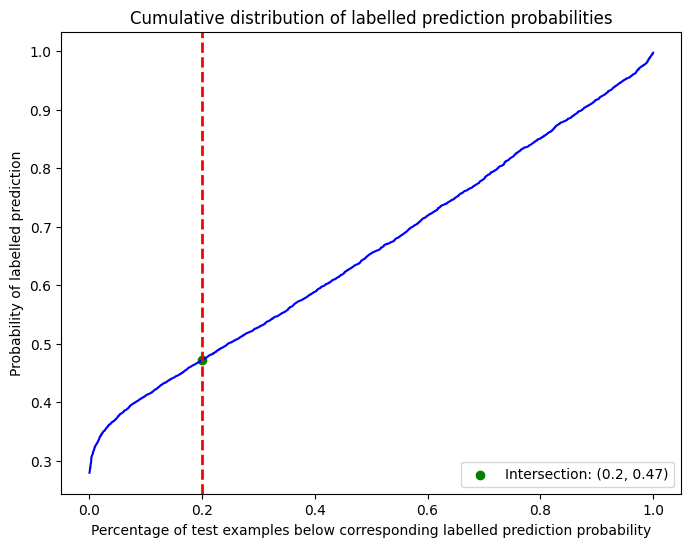

In [241]:
REJECTION_PERCENTAGE = 0.2 # percentage of examples that are rejected 

y_pred_prob = model.predict_proba(X_test_final)
y_pred_prob_max = np.sort(np.max(y_pred_prob, axis=1))
x_range = np.arange(1, len(y_pred_prob_max) + 1) / len(y_pred_prob_max)

rejection_index = int(len(y_pred_prob_max) * REJECTION_PERCENTAGE)
labelled_prediction_rejection_prob = y_pred_prob_max[rejection_index]

plt.figure(figsize=(8, 6))
plt.plot(x_range, y_pred_prob_max, color='b')
plt.axvline(REJECTION_PERCENTAGE, color='r', linestyle='--', linewidth=2)
plt.scatter(REJECTION_PERCENTAGE, labelled_prediction_rejection_prob, color='green', label=f'Intersection: ({REJECTION_PERCENTAGE}, {labelled_prediction_rejection_prob:.2f})')
plt.legend()
plt.xlabel('Percentage of test examples below corresponding labelled prediction probability')
plt.ylabel('Probability of labelled prediction')
plt.title('Cumulative distribution of labelled prediction probabilities')
plt.show()

#### Rejection of classification - rejection by distance in document embedding space

### Extra code

In [ ]:
# # do prediction on training data
# y_train_predicted = model.predict(X_train)

# # obtain training f1 score
# f1_score(y_train, y_train_predicted, average='macro') # TODO this tests the model on its already trained set...

In [ ]:
# # obtain predictions on test data
# y_pred = model.predict(X_test)

# # obtain test f1 score
# f1_score(y_test, y_pred, average= 'macro')

In [ ]:
### Hyper Parameter tuning with GridSearchCV()

In [ ]:
### Jian Hui end

In [ ]:
### <Group Member's name> start

In [ ]:
# Group member's code here

In [ ]:
### <Group Member's name> end

# DEPRECATED FEATURES

In [ ]:

# 2) Sentiment analysis
# def sentiment_analysis(sentence):
#     doc = spacy_model(sentence)
#     return doc._.blob.polarity

# X_train_sent_ana = X_train_unprocessed.apply(sentiment_analysis).to_numpy().reshape(-1, 1)

# ## Analysis of sentiment feature
# count_analysis(X_train_sent_ana, y_train)

# # Save sentiment analysis output
# pd_sent_ana = pd.DataFrame(X_train_sent_ana, columns=["Sentiment"])
# compression_opts = dict(method='zip', archive_name='sent_ana.csv')
# pd_sent_ana.to_csv('features/sent_ana.zip', index=False, compression=compression_opts)

# 3) Subjectivity analysis 
# def subjectivity_analysis(sentence):
#     doc = spacy_model(sentence)
#     return doc._.blob.subjectivity

# X_train_subj_ana = X_train_unprocessed.apply(subjectivity_analysis).to_numpy().reshape(-1, 1)

# ## Analysis of subjectivity feature
# count_analysis(X_train_subj_ana, y_train)

# # Save sentiment analysis output
# pd_subj_ana = pd.DataFrame(X_train_subj_ana, columns=["Subjectivity"])
# compression_opts = dict(method='zip', archive_name='subj_ana.csv')
# pd_subj_ana.to_csv('features/subj_ana.zip', index=False, compression=compression_opts)

# 4) Number of exclamation and question marks (pre-analyze first)
# def count_exclamation_marks(sentence):
#     return len(re.findall(r'\!', sentence))

# def count_question_marks(sentence):
#     return len(re.findall(r'\?', sentence))

# X_train_count_ex = X_train.apply(count_exclamation_marks).to_numpy().reshape(-1, 1)
# X_train_count_qn = X_train.apply(count_question_marks).to_numpy().reshape(-1, 1)

# count_analysis(X_train_count_ex, y_train, "Exclamation mark")
# count_analysis(X_train_count_qn, y_train, "Question mark")

# 5) Count number of sentences
# def count_sentences(sentences):
#     return len(nltk.sent_tokenize(sentences)) 

# X_train_count_sentences = X_train.apply(count_sentences).to_numpy().reshape(-1, 1)
# count_analysis_scatter(X_train_count_sentences, y_train, "sentence_count")

# 7) text2emotion (takes too around 6 hours)
# def emotion_vector(sentences):
#     res = np.zeros((len(sentences), 5)) # Angry, Fear, Happy, Sad, Surprise
#     row = 0
#     for sentence in sentences:
#         d = te.get_emotion(sentence)
#         emotion_sorted = sorted(d.items(), key=lambda tup: tup[0])
#         values = np.fromiter(map(lambda tup: tup[1], emotion_sorted), dtype=float)
#         res[row] = values
#         row += 1
#     return res

# X_train_emotion = emotion_vector(X_train_unprocessed).to_numpy().reshape(-1, 1)
# count_analysis_scatter(X_train_emotion[:, 0], y_train, "emotion_angry")
# count_analysis_scatter(X_train_emotion[:, 1], y_train, "emotion_fear")
# count_analysis_scatter(X_train_emotion[:, 2], y_train, "emotion_happy")
# count_analysis_scatter(X_train_emotion[:, 3], y_train, "emotion_sad")
# count_analysis_scatter(X_train_emotion[:, 4], y_train, "emotion_surprise")
